In [1]:
"""
Link: https://pyro.ai/examples/svi_part_i.html

We try to approximate what we think our mode llooks like in a model and then we specify
the guide which should be a parametrisable distribution that approximates the posterior: 

The basic idea is that we introduce a parameterized distribution qϕ(z)
, where ϕ are known as the variational parameters.
This distribution is called the variational distribution in
much of the literature, and in the context of Pyro it’s called the guide
(one syllable instead of nine!). 
The guide will serve as an approximation to the posterior

Just like the model, the guide is encoded as a stochastic function guide()
that contains pyro.sample and pyro.param statements.
It does not contain observed data, since the guide needs to be a properly
normalized distribution. Note that Pyro enforces that model() and guide()
have the same call signature, i.e. both callables should take the same arguments.

Since the guide is an approximation to the posterior pθmax(z|x),
the guide needs to provide a valid joint probability density
over all the latent random variables in the model. 
Recall that when random variables are specified in Pyro with
the primitive statement pyro.sample() the first argument denotes
the name of the random variable. These names will be used to align
the random variables in the model and guide. To be very explicit,
if the model contains a random variable z_1
"""

'\nLink: https://pyro.ai/examples/svi_part_i.html\n\nWe try to approximate what we think our mode llooks like in a model and then we specify\nthe guide which should be a parametrisable distribution that approximates the posterior: \n\nThe basic idea is that we introduce a parameterized distribution qϕ(z)\n, where ϕ are known as the variational parameters.\nThis distribution is called the variational distribution in\nmuch of the literature, and in the context of Pyro it’s called the guide\n(one syllable instead of nine!). \nThe guide will serve as an approximation to the posterior\n\nJust like the model, the guide is encoded as a stochastic function guide()\nthat contains pyro.sample and pyro.param statements.\nIt does not contain observed data, since the guide needs to be a properly\nnormalized distribution. Note that Pyro enforces that model() and guide()\nhave the same call signature, i.e. both callables should take the same arguments.\n\nSince the guide is an approximation to the po

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO


pyro.set_rng_seed(101)

In [3]:
# Suppose we are trying to figure out how much something weighs,
# but the scale we’re using is unreliable and gives slightly different
# answers every time we weigh the same object. 
# We could try to compensate for this variability by integrating the
# noisy measurement information with a guess based on some prior knowledge
# about the object, like its density or material properties. 
def model(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75), obs = torch.tensor(9.5))

# Define learnable parameters for our measurement 
def guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

In [4]:
"""
The user needs to provide three things: the model, the guide, and an optimizer.
We’ve discussed the model and guide above and we’ll discuss the optimizer
in some detail below, so let’s assume we have all three ingredients at hand.
To construct an instance of SVI that will do optimization via the ELBO objective, the user writes
"""
pyro.clear_param_store()

adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
optimizer = pyro.optim.Adam(adam_params)
"""
In Pyro, the model and guide are allowed to be arbitrary stochastic functions provided that

guide doesn’t contain pyro.sample statements with the obs argument
model and guide have the same call signature

This presents some challenges because it means that different executions
of model() and guide() may have quite different behavior, with e.g.
certain latent random variables and parameters only appearing some of the time.
Indeed parameters may be created dynamically during the course of inference.
In other words the space we’re doing optimization over, 
which is parameterized by θ and ϕ, can grow and change dynamically.

"""

In [ ]:

# Specify number of samples with respect to which we should try and compute the gradient e.g.:12
svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_particles = 12))

# svi.step() < single step and calculation of the gradient 
# svt.evaluate_loss() , returns an estimate of the loss without taking a gradient step 

a =  9.150269508361816
b =  0.6036313772201538


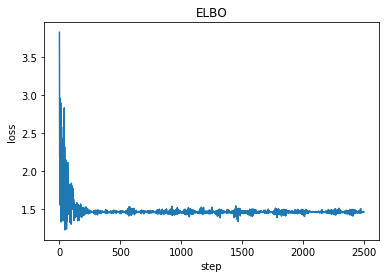

In [6]:
losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(8.5))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())